# Gaussian mixture scheduling toy example

Through a toy example, this notebook explores the possibility for scheduling agents' activities using a Gaussian Mixture Neural Network.

## The problem

We want to model the duration of activities as a multimodal probability distribution.

For example, let's create a toy population with home->work->home plans.

Some of those agents are working full-time (8 hours), and some of them part time (4 hours).

Of course, not all full-time agents are working exactly 8 hours - we would expect to see a distribution centered around this value. The same goes for part-time agents.

We are creating a PAM population around those assumptions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pam.activity import Activity, Trip
from pam.core import Person, Population
from pam.planner import choice_scheduling
from pam.planner.encoder import PlansSequenceEncoder
from pam.utils import minutes_to_datetime as mtdt


2024-06-03 16:42:55.243704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Means:  [0.167 0.333]
Sds:  [0.008 0.046]
Weights:  [0.3 0.7]


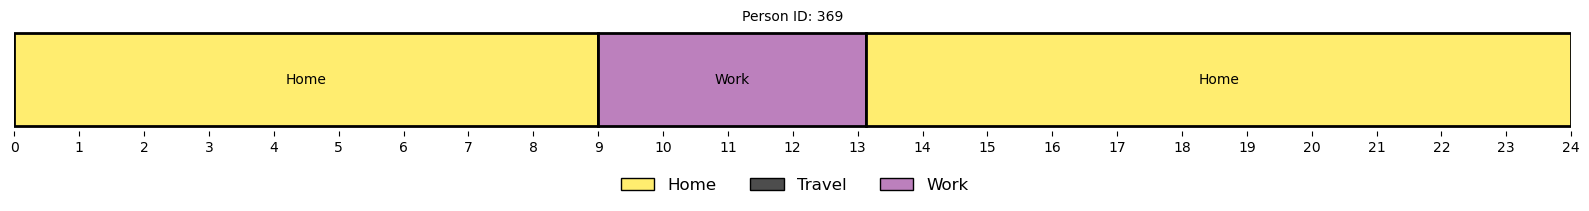

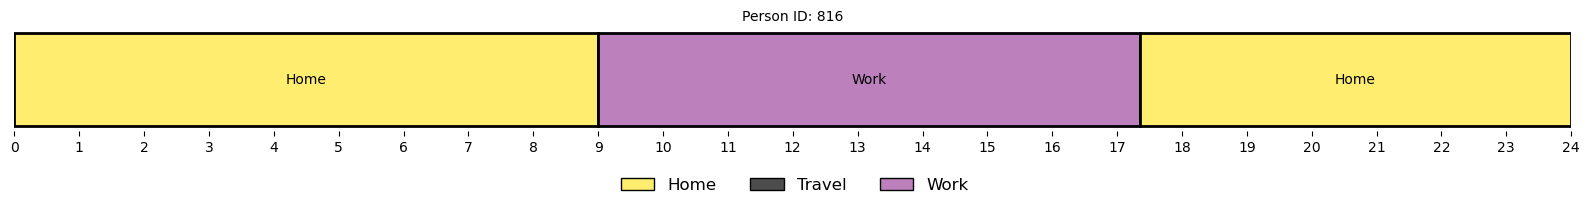

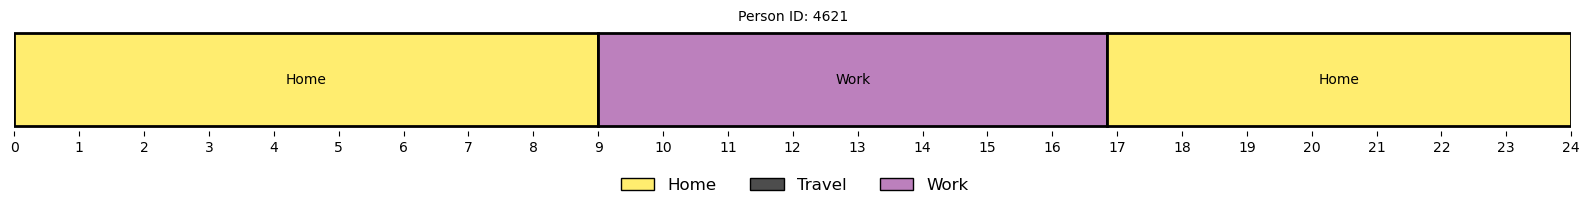

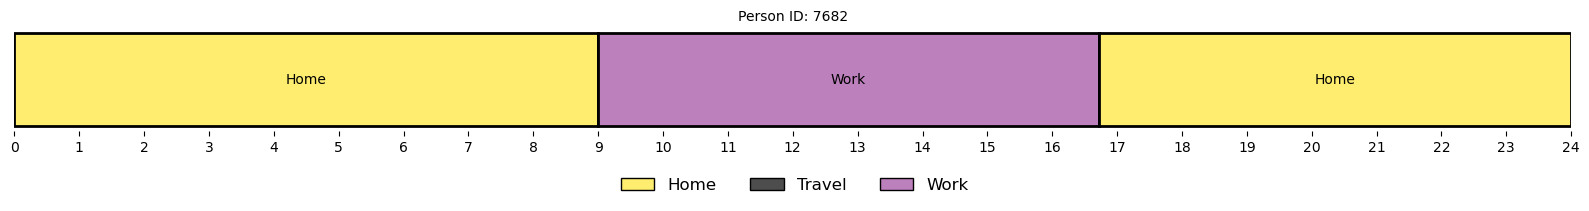

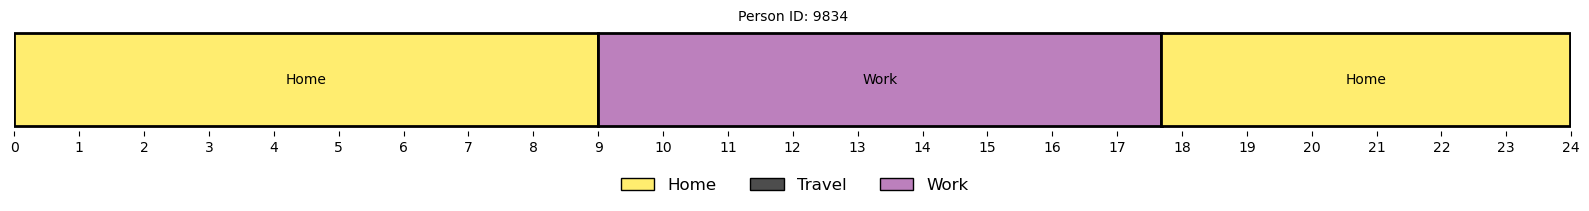

In [2]:
means = np.array([4, 8]) / 24
sds = np.array([0.2, 1.1]) / 24
weights = np.array([0.3, 0.7])

print("Means: ", means.round(3))
print("Sds: ", sds.round(3))
print("Weights: ", weights)

n_agents = 10**4

# work starts at 8
population = Population()
for i in range(n_agents):
    person = Person(pid=i)

    # sample work duration
    idist = np.random.choice([0, 1], size=1, p=weights)
    work_duration = np.random.normal(loc=means[idist], scale=sds[idist]) * 24

    # times
    ts_work_start = mtdt(9 * 60)
    ts_work_end = mtdt(9 * 60 + work_duration * 60)

    # create plan
    person.add(Activity(act="home", start_time=mtdt(0), end_time=ts_work_start))
    person.add(Trip(start_time=ts_work_start, end_time=ts_work_start, mode="walk"))
    person.add(Activity(act="work", start_time=ts_work_start, end_time=ts_work_end))
    person.add(Trip(start_time=ts_work_end, end_time=ts_work_end, mode="walk"))
    person.add(Activity(act="home", start_time=ts_work_end, end_time=mtdt(24 * 60)))
    population.add(person)

for i in range(5):
    population.random_person().plot()
plt.show()

As per our data generation process, the duration of work activities has two peaks, normaly distributed around 4 and 8 hours:

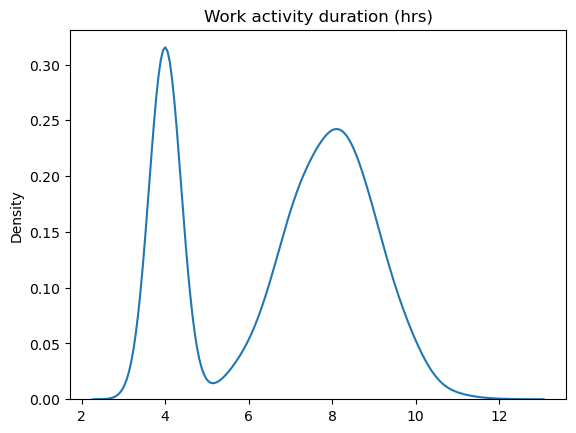

In [3]:
plans_encoder = PlansSequenceEncoder(population)
acts = plans_encoder.acts[:, 2]
durations = plans_encoder.durations[:, 2]

sns.kdeplot(durations*24)
plt.title("Work activity duration (hrs)")
plt.show()

## Modelling

### Regression model

A regression Neural Network predicts the same value every time it sees the same input:

In [4]:
acts = plans_encoder.acts[:, [2]]
durations = plans_encoder.durations[:, 2]

In [5]:
model_regression = choice_scheduling.ActivityDurationRegression(
    acts = acts,
    durations = durations
)
model_regression.fit()

# in-place prediction
y_pred = model_regression.predict(acts)
y_pred

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141 (4.46 KB)

 Trainable params: 1,141 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0081
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0075
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0076
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0080  
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0078
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0079  
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.0000e+00 - loss: 0.0077
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.0000e+00 - loss: 0.0076
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0076
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0076
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0075
Epoch 12/20

array([[0.26840803],
       [0.26840803],
       [0.26840803],
       ...,
       [0.26840803],
       [0.26840803],
       [0.26840803]], dtype=float32)

(0.0, 12.0)

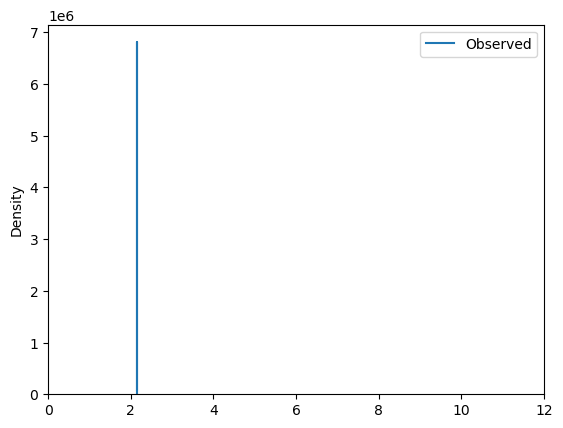

In [6]:
sns.kdeplot(y_pred[:, 0]*8)
plt.legend(["Observed", "Predicted"])
plt.xlim(0, 12)

### Mixture Density Network

With the `choice_sheduling.ActivityDurationMixture` class, we train a Mixture Density Neural Network (MDN) to capture the variation and multi-modality of the plans:

In [10]:
model_mixture = choice_scheduling.ActivityDurationMixture(
    acts = acts,
    durations = durations
)
model_mixture.fit(epochs=50)

# in-place prediction
y_pred = model_mixture.predict(acts)
y_pred

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_3 (Dense)             (None, 50)                100       
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 6)                 126       
                                                                 
 output (MixtureNormal)      ((None, 1),               0         
                              (None, 1))                         
                                                                 
Total params: 1246 (4.87 KB)
Trainable params: 1246 (4.87 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

313/313 [==============================] - 3s 2ms/step - loss: -0.8754 - accuracy: 0.0000e+00
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: -1.0220 - accuracy: 0.0000e+00
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: -1.0291 - accuracy: 0.0000e+00
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: -1.0787 - accuracy: 0.0000e+00
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: -1.2610 - accuracy: 0.0000e+00
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: -1.4380 - accuracy: 0.0000e+00
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: -1.4483 - accuracy: 0.0000e+00
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: -1.4812 - accuracy: 0.0000e+00
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: -1.4556 - accuracy: 0.0000e+00
Epoch 10/50
313/313 [==============================] - 1s 2ms/step

array([[0.40166548],
       [0.30696756],
       [0.16760828],
       ...,
       [0.43532485],
       [0.31790522],
       [0.2922432 ]], dtype=float32)

(0.0, 12.0)

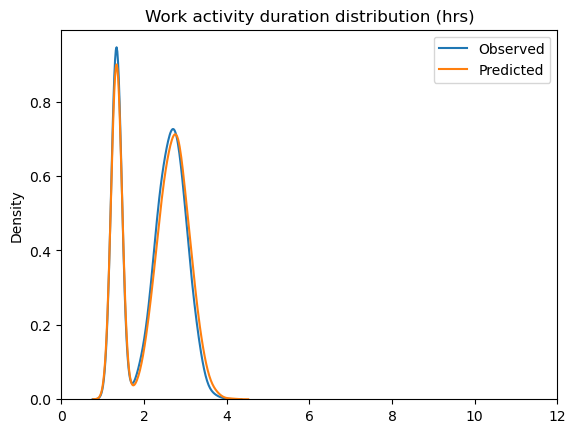

In [11]:
sns.kdeplot(durations*8)
sns.kdeplot(y_pred[:, 0]*8)
plt.legend(["Observed", "Predicted"])
plt.title("Work activity duration distribution (hrs)")
plt.xlim(0, 12)

We find that the MDN model is able to replicate the observed patterns in a more realistic way.